# Google Colab: Access Webcam for Images and Video


In [ ]:
#Code modified from https://github.com/theAIGuysCode/colab-webcam

# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import tensorflow as tf
from google.colab import drive
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Helper Functions
Below are a few helper function to make converting between different image data types and formats. 

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

## Webcam Images
Using the code snippet for **Camera Capture** to utilize your computer's webcam.

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

## Webcam Videos
Running code on webcam video is a little more complex than images. We need to start a video stream using our webcam as input. Then we run each frame through our progam (face detection) and create an overlay image that contains bounding box of detection(s). We then overlay the bounding box image back onto the next frame of our video stream.

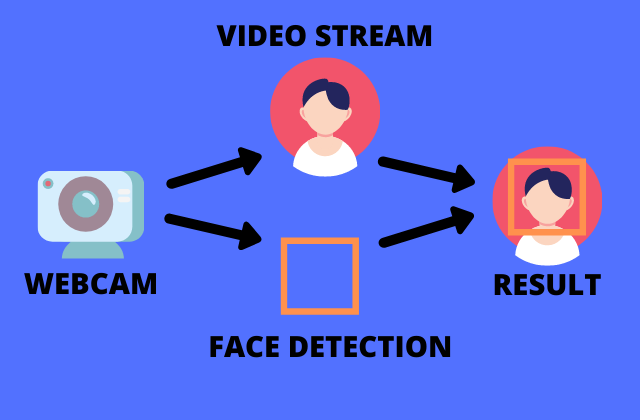</center>

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 64, 64);  // 640, 480 
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 64; //video.videoWidth
      captureCanvas.height = 64; //video.videoHeight
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
##### Everything Below this line was created my CDT Jack Summers #####

#import model
drive.mount('/content/drive')

model_path = '/content/drive/My Drive/checkpoint/model_v8.h5'
reconstructed_model = keras.models.load_model(model_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Custom functions

def decode(x): #convert np prediction into char
  i = np.argmax(x[0]) #find index of max value
  alpha = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ']
  return (alpha[i])


def mode(x): # find most common prediction
  dic = {}
  for item in x:
    if item in dic: #counting total number of occurences for each class within 10 frames
      dic[item] +=1 
    else:
      dic[item] = 1
  return max(dic, key=dic.get) # retrun the most frequent class


In [ ]:
# start streaming video from webcam
import matplotlib.pyplot as plt
video_stream()
# label for video
label_html = 'Capturing...'
bbox =''
count = 0 


import numpy as np

def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray
l = []
while True:
    if count != 10:
      count += 1
      js_reply = video_frame(label_html, bbox)
      if not js_reply:
          break

      # convert JS response to OpenCV Image
      img = js_to_image(js_reply["img"])
      

      ##################
      # for grayscale
      #gray_img = rgb2gray(img)
      #gray_img = gray_img.reshape(1, 64, 64, 1)
      #datagen = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)
      #gen = datagen.flow(gray_img)
      ##################
      #reshape and normalize
      
      img = img.reshape(1, 64, 64, 3) #/ 255 #300 
     
      datagen = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)

      gen = datagen.flow(img)
      

      predictions = reconstructed_model.predict(gen)
      l.append(decode(predictions))
     
    else:
      #print(l)
      label_html = mode(l)
      l =[]
      count = 0
      continue

  

MessageError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


y


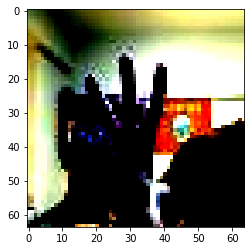

In [ ]:
plt.imshow(im[0])
plt.imshow(Pim[0][0])
print(pred[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


f


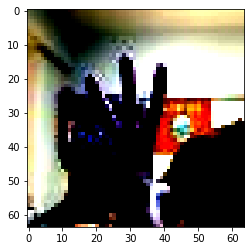

In [ ]:
plt.imshow(im[1])
plt.imshow(Pim[1][0])
print(pred[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


k


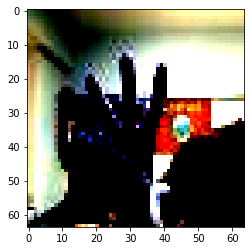

In [ ]:
plt.imshow(im[2])
plt.imshow(Pim[2][0])
print(pred[2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


k


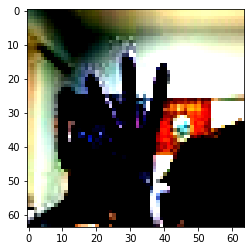

In [ ]:
plt.imshow(im[3])
plt.imshow(Pim[3][0])
print(pred[3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


f


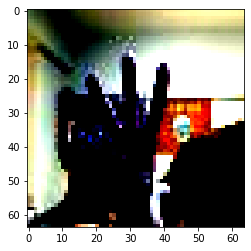

In [ ]:
plt.imshow(im[4])
plt.imshow(Pim[4][0])
print(pred[4])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


f


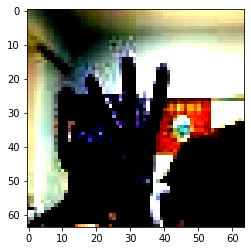

In [ ]:
plt.imshow(im[5])
plt.imshow(Pim[5][0])
print(pred[5])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


f


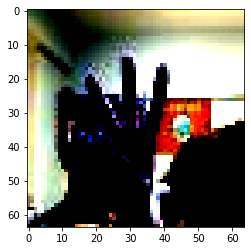

In [ ]:
plt.imshow(im[6])
plt.imshow(Pim[6][0])
print(pred[6])